In [1]:
import os
import warnings
import matplotlib
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from typing import TYPE_CHECKING, Any, Callable, Dict, List, Optional, Tuple

import gradio as gr
import torch
import torch.nn.functional as F
import argparse
import whisper
import numpy as np
import cv2
import glob
import time
import scipy
import json
from scipy import ndimage
from scipy.spatial import distance

from torchvision import transforms
from torchvision.ops.boxes import batched_nms
from detectron2.data import MetadataCatalog
from utils.visualizer import Visualizer

from gradio import processing_utils
from modeling.BaseModel import BaseModel
from modeling import build_model
from utils.distributed import init_distributed
from utils.arguments import load_opt_from_config_files
from utils.constants import COCO_PANOPTIC_CLASSES
from detectron2.data.datasets.builtin_meta import COCO_CATEGORIES


# from demo.seem.tasks import *


from vgg import vgg19


from sam_3d_utils import show_mask, show_points

from run_gen_sam_labels import count_with_sam_recursive, semantic_sam_seg

/home/jiawan/anaconda3/envs/adaseem/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Deformable Transformer Encoder is not available.


$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([134])


In [2]:
# SEEM initialization 
def parse_option():
    parser = argparse.ArgumentParser('SEEM Demo', add_help=False)
    parser.add_argument('--conf_files', default="configs/seem/focall_unicl_lang_demo.yaml", metavar="FILE", help='path to config file', )
    cfg = parser.parse_args('')
    return cfg

'''
build args
'''
cfg = parse_option()
opt = load_opt_from_config_files([cfg.conf_files])
opt = init_distributed(opt)

opt['MODEL']['DECODER']['TEST']['OBJECT_MASK_THRESHOLD'] = 0.3

# META DATA
cur_model = 'None'
if 'focalt' in cfg.conf_files:
    pretrained_pth = os.path.join("seem_focalt_v0.pt")
    if not os.path.exists(pretrained_pth):
        os.system("wget {}".format("https://huggingface.co/xdecoder/SEEM/resolve/main/seem_focalt_v0.pt"))
    cur_model = 'Focal-T'
elif 'focal' in cfg.conf_files:
    pretrained_pth = os.path.join("seem_focall_v0.pt")
    if not os.path.exists(pretrained_pth):
        os.system("wget {}".format("https://huggingface.co/xdecoder/SEEM/resolve/main/seem_focall_v0.pt"))
    cur_model = 'Focal-L'

print(cur_model)

'''
build model
'''
model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(COCO_PANOPTIC_CLASSES + ["background"], is_eval=True)

audio = whisper.load_model("base") # audio is not used in our method

Focal-L


$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([134])


In [3]:
# helper visualization function
def visualize(image, masks, bbxes):
    w, h = image.size
    # left is the semantic map, right is the mask
    fig = plt.figure(figsize=(10,10))

    # fig.add_subplot(1, 2, 1)
    # plt.imshow(image)
    # plt.imshow(semantic_map.cpu().numpy(), alpha=0.5)
    # fig.add_subplot(1, 2, 2)

    plt.imshow(image)
    ax = plt.gca()
    m = np.zeros((h, w))
    # plt.imshow(pano_seg.cpu().numpy(), alpha=0.5)
    for bbx, mask in zip(bbxes, masks):
        rect = matplotlib.patches.Rectangle((bbx[0], bbx[1]), bbx[2]-bbx[0], bbx[3]-bbx[1], edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        m[bbx[1]:bbx[3], bbx[0]:bbx[2]] = mask + m[bbx[1]:bbx[3], bbx[0]:bbx[2]]
    plt.imshow(m > 0, alpha=0.5)
    plt.axis('off')
    plt.show()

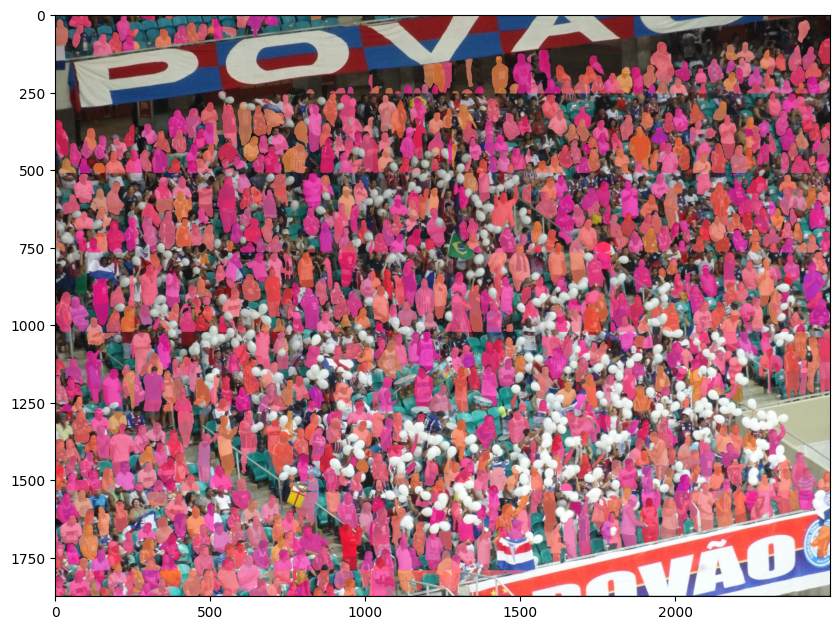

In [4]:
# a simple demo
img_path = './img_0001.png'
image = Image.open(img_path).convert('RGB') 

cnt, pano_pred, sem_map, person_map = count_with_sam_recursive(image, model, size=1024, thr=0.3, min_size=128)

fig = plt.figure(figsize=(10,10))
plt.imshow(pano_pred)
# plt.axis('off')
plt.show()